In [21]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries
%matplotlib inline
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
from shapely.geometry import Point, LineString, Polygon
from functools import partial
import pyproj
from shapely.ops import transform
import numpy as np

C:\Users\gabri\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
villa_lobos = gpd.read_file("../../data/Cidade de São Paulo/Parques/villa_lobos.geojson")

In [64]:
#receives the polygon of the place
#output: gdf of buffer area of the building (dist=0.003)

def get_buffer(building):
    buffer_building = building.buffer(distance=0.01)
    
    distance = 0.001
    
    #making buffer a geodataframe
    buffer_gdf = gpd.GeoDataFrame(buffer_building)
    
    #setting buffer's geometry
    geometria = building['geometry'].buffer(distance) 
    buffer_gdf.set_geometry(geometria, inplace=True)
    
    return(buffer_gdf)

In [18]:
def get_streets_buildings2(coordinates_p):

    dist = 2300

    #streets
    G2 = ox.graph_from_point(coordinates_p, network_type='drive', dist=dist)
    #making it a geodataframe
    G2_nodes, G2_edges = ox.graph_to_gdfs(G2)
    
    #some problematic columns of G2_edges must be converted into type str
    problematic = [
        "osmid",
        "bridge",
        "oneway",
        "lanes",
        "ref",
        "name",
        "highway",
        "maxspeed",
        "reversed",
        "access",
        "junction",
        "width"
    ]
    
    columns_to_convert = list(set(problematic) & set(G2_edges.columns))
    
    #convert selected columns, if they exist, to string format
    G2_edges[columns_to_convert] = G2_edges[columns_to_convert].astype(str)

    streets = G2_edges
    
    #buildings
    tags = {"building": True}
    buildings = ox.geometries_from_point(coordinates_p, tags, dist=dist)
    buildings_proj = ox.project_gdf(buildings)
    bbox = ox.utils_geo.bbox_from_point(point=coordinates_p, dist=dist, project_utm=True)
    
    buildings = buildings[['geometry', 'name', 'addr:street']]
    
    return(streets, buildings)

In [65]:
buffer_villa_lobos = get_buffer(villa_lobos)

C:\Users\gabri\AppData\Local\Temp\ipykernel_2676\3075527352.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer_building = building.buffer(distance=0.01)
C:\Users\gabri\AppData\Local\Temp\ipykernel_2676\3075527352.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometria = building['geometry'].buffer(distance)


<AxesSubplot: >

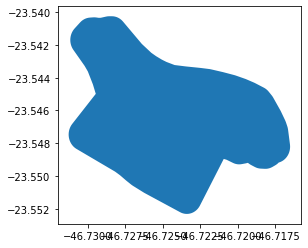

In [66]:
buffer_villa_lobos.plot()

In [19]:
coordinates_park = (-23.546133451196493, -46.72542586599279)

In [22]:
streets, buildins = get_streets_buildings2(coordinates_park)

In [34]:
buildings = buildins

<AxesSubplot: >

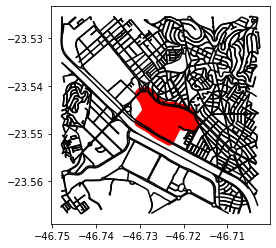

In [68]:
ax = buffer_villa_lobos.plot(color="red", edgecolor="red")
streets.plot(ax=ax, color="black")

In [69]:
buffer_villa_lobos["name"] = "Buffer Villa Lobos"

In [70]:
buffer_villa_lobos['ID'] = np.arange(len(buffer_villa_lobos))
buffer_villa_lobos.set_index('ID', inplace=True)


In [71]:
buffer_villa_lobos = buffer_villa_lobos[["name", "geometry"]]
buffer_villa_lobos

,name,geometry
ID,,
0,Buffer Villa Lobos,"POLYGON ((-46.73094 -23.54231, -46.73100 -23.5..."


In [72]:
import os
dir = '../../data/Cidade de São Paulo/Parques'

if not os.path.exists(dir): 
    os.makedirs(dir)
#se essa pasta não existir, crio ela

In [73]:
buffer_villa_lobos.to_file(dir + '/villa_lobos_buffer.geojson')